# TASK 2: RAG (RETRIVER ARGUMENTED GENERATION)

### **Overview of GEPA for RAG (Retrieval-Augmented Generation)**
This notebook implements the **GEPA** framework specifically optimized for **RAG** systems.
In RAG, the prompt isn't just about generation style; it must also effectively instruct the **Retrieval** step (what to look for) and the **Reasoning** step (how to use the context).
GEPA evolves both retrieval instructions and generation prompts simultaneously to maximize **Context Recall** and **Answer Faithfulness**.


In [ ]:
# Install required packages
%pip install numpy pandas seaborn matplotlib tqdm sentence-transformers faiss-cpu PyPDF2 dspy-ai


### **1. Environment & API Setup**
We initialize the environment with `dspy`, `faiss` for vector search, and `sentence-transformers` for embeddings.
We use a **Groq-hosted Llama-3** model for the high-quality reasoning required in the evaluation loop, while using a lightweight local model for mutation.


In [1]:
import os
import math
import json
import numpy as np
import faiss
from typing import List, Dict, Any, Tuple
from dataclasses import dataclass, field
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import dspy
from sentence_transformers import SentenceTransformer
import PyPDF2
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("All imports successful")

All imports successful


LLM INITILIZATION (If Using Grok)

In [ ]:
%pip install getpass langchain_groq langchain_core

In [2]:

import getpass
api_key = getpass.getpass("Enter your GROQ API key: ")

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage

class GroqLM(dspy.LM):
    def __init__(self, model="llama-3.3-70b-versatile", api_key=None, **kwargs):
        super().__init__(model=model, **kwargs)
        self.model_name = model
        self.client = ChatGroq(model=model, api_key=api_key)
    
    def __call__(self, prompt=None, messages=None, **kwargs):
        if messages:
            lc_messages = []
            for msg in messages:
                if msg.get("role") == "system":
                    lc_messages.append(SystemMessage(content=msg["content"]))
                elif msg.get("role") == "user":
                    lc_messages.append(HumanMessage(content=msg["content"]))
            response = self.client.invoke(lc_messages)
        else:
            response = self.client.invoke([HumanMessage(content=prompt)])
        return [response.content]

# Initialize LM (use your actual API key)
lm = GroqLM(api_key=api_key)
dspy.configure(lm=lm)


# hf_api_key = getpass.getpass("Enter your Hugging Face API key: ")
# from huggingface_hub import InferenceClient
# # Initialize HF Client globally
# hf_client = InferenceClient(token=hf_api_key)


PDF EXTRACTION AND TEXT PROCESSING

### **2. Data Ingestion & Chunking**
To perform RAG, we first need a knowledge base.
We load a PDF, normalize the text, and split it into overlapping chunks (e.g., 800 chars).
These chunks will be our "search space".


In [3]:
def extract_pdf_text(path: str) -> str:
    """Extract text from PDF file"""
    text = ""
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            page_text = page.extract_text() or ""
            text += page_text + "\n"
    return text

def normalize_text(s: str) -> str:
    """Normalize text for comparison"""
    import re
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = " ".join(s.split())
    return s

def chunk_text(text: str, max_chars: int = 800, overlap: int = 100) -> List[str]:
    """Chunk text with overlap"""
    chunks = []
    start = 0
    while start < len(text):
        end = min(len(text), start + max_chars)
        chunk = text[start:end]
        chunks.append(chunk.strip())
        if end == len(text):
            break
        start = end - overlap
    return [c for c in chunks if c]


EMBEDDING AND VECTOR INDEX

### **3. Vector Indexing (FAISS)**
We use `SentenceTransformer` (all-MiniLM-L6-v2) to encode text chunks into vectors.
`FAISS` is used to build a fast similarity index, allowing us to retrieve relevant context for any given query.


In [4]:
# Initialize embedding model globally
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

def embed_texts(texts: List[str]) -> np.ndarray:
    """Generate embeddings for texts"""
    return np.array(embed_model.encode(texts, convert_to_numpy=True), dtype="float32")

class VectorIndex:
    """FAISS-based vector index for retrieval"""
    
    def __init__(self, chunks: List[str]):
        self.chunks = chunks
        embeddings = embed_texts(chunks)
        dim = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        # Normalize for cosine similarity
        faiss.normalize_L2(embeddings)
        self.embeddings = embeddings
        self.index.add(self.embeddings)
    
    def search(self, query: str, k: int = 4) -> List[Dict[str, Any]]:
        """Search for top-k similar chunks"""
        q_emb = embed_texts([query])
        faiss.normalize_L2(q_emb)
        scores, idxs = self.index.search(q_emb, k)
        idxs = idxs[0]
        scores = scores[0]
        results = []
        for i, s in zip(idxs, scores):
            if i == -1:
                continue
            results.append({"text": self.chunks[i], "score": float(s), "idx": int(i)})
        return results

LOAD AND INDEX PDF

In [5]:
# Load PDF
pdf_path = "/mnt/a/Projects/Prompt_Optimizer/pdfs/Why Machines Learn PDF.pdf"
print(f"\nLoading PDF: {pdf_path}")

doc_text = extract_pdf_text(pdf_path)
doc_text = normalize_text(doc_text)
chunks = chunk_text(doc_text, max_chars=800, overlap=100)
vector_index = VectorIndex(chunks)

print(f" Built index with {len(chunks)} chunks")
print(f"  Document length: {len(doc_text):,} characters")


Loading PDF: /mnt/a/Projects/Prompt_Optimizer/pdfs/Why Machines Learn PDF.pdf
 Built index with 161 chunks
  Document length: 112,762 characters
 Built index with 161 chunks
  Document length: 112,762 characters


BASELINE RAG SYSTEM

### **4. Baseline RAG System**
A standard DSPy implementation of RAG.
It retrieves top-k chunks and feeds them into a static `ChainOfThought` module.
This serves as the benchmark to beat.


In [6]:
class RAGQASignature(dspy.Signature):
    """Answer a question using retrieved context from a PDF."""
    
    question: str = dspy.InputField(desc="User question about the PDF.")
    contexts: List[str] = dspy.InputField(desc="List of retrieved passages from the PDF.")
    
    answer: str = dspy.OutputField(desc="Final answer grounded in the provided contexts.")
    answer_confidence: float = dspy.OutputField(desc="Self-estimated confidence 0–1.")
    faithfulness_score: float = dspy.OutputField(
        desc="Self-rated how well the answer is supported by the contexts, 0–1."
    )
    coverage_score: float = dspy.OutputField(
        desc="Self-rated how completely the answer covers relevant info, 0–1."
    )

class BaselineRAG(dspy.Module):
    """Baseline RAG QA System"""
    
    def __init__(self, index: VectorIndex, k: int = 4):
        super().__init__()
        self.index = index
        self.k = k
        self.qa = dspy.ChainOfThought(RAGQASignature)
    
    def retrieve(self, question: str) -> List[str]:
        """Retrieve relevant chunks"""
        results = self.index.search(question, k=self.k)
        return [r["text"] for r in results]
    
    def forward(self, question: str):
        """Execute RAG pipeline"""
        contexts = self.retrieve(question)
        joined_contexts = [f"[Chunk {i+1}]\n{c}" for i, c in enumerate(contexts)]
        
        result = self.qa(question=question, contexts=joined_contexts)
        
        return dspy.Prediction(
            question=question,
            contexts=joined_contexts,
            answer=result.answer,
            answer_confidence=result.answer_confidence,
            faithfulness_score=result.faithfulness_score,
            coverage_score=result.coverage_score,
        )


GEPA COMPONENTS - PROMPT CANDIDATE STRUCTURE

### **5. GEPA Architecture: RAG Prompt DNA**
A `RAGPromptCandidate` is more complex than a summary prompt. It consists of:
- **Retrieval Instruction**: How to formulate the search query or what to prioritize (e.g., "Find semantic matches", "Find exact keyword hits").
- **Reranking Strategy**: Conceptual instructions on how to weigh retrieved chunks.
- **Generation Prefix**: How to synthesize the answer.
- **Grounding Emphasis**: Instructions to strictly adhere to the provided context.


In [7]:
@dataclass
class RAGPromptCandidate:
    """Prompt candidate for RAG optimization"""
    
    # Retrieval instructions
    retrieval_instruction: str
    reranking_strategy: str
    
    # Generation instructions
    generation_prefix: str
    answer_format: str
    grounding_emphasis: str
    
    # Metadata
    score: float = 0.0
    performance_metrics: Dict[str, float] = field(default_factory=dict)
    
    def to_dict(self):
        return {
            'retrieval_instruction': self.retrieval_instruction,
            'reranking_strategy': self.reranking_strategy,
            'generation_prefix': self.generation_prefix,
            'answer_format': self.answer_format,
            'grounding_emphasis': self.grounding_emphasis,
            'score': self.score,
            'performance_metrics': self.performance_metrics
        }


GEPA - CANDIDATE POOL INITIALIZATION

### **6. Step 1: Initial Population (Local LLM)**
We effectively use the local **Qwen-0.5B** model to brainstorm diverse strategies for retrieval and generation.
This creates a rich starting population of candidates.


In [8]:
class RAGCandidatePoolInitializer:
    # \"\"\"Initialize diverse pool of RAG prompt candidates\"\"\"
    
    def __init__(self, pool_size: int = 12):
        self.pool_size = pool_size
    
    def generate_initial_pool(self) -> List[RAGPromptCandidate]:
        # \"\"\"Generate diverse RAG prompt candidates using local model pipeline\"\"\"
        print("Generating initial pool via local Qwen-0.5B pipeline...")
        
        def get_generated_list(prompt_desc, count=4):
            try:
                # Initialize pipeline if not present
                generator = globals().get('local_generator')
                if not generator:
                    from transformers import pipeline
                    import torch
                    print("Loading Qwen/Qwen2.5-0.5B-Instruct (this may take a moment)...")
                    # Use CPU to be safe, or cuda if available
                    device = 0 if torch.cuda.is_available() else -1
                    generator = pipeline(
                        "text-generation", 
                        model="Qwen/Qwen2.5-0.5B-Instruct", 
                        device=device,
                        max_new_tokens=256,
                        pad_token_id=50256 # Default for safety if missing
                    )
                    globals()['local_generator'] = generator
                
                # ChatML format manually for robustness
                user_msg = (
                    f"Generate {count} diverse and distinct {prompt_desc}. "
                    "Return ONLY a pure Python list of strings. "
                    "Example format: ['item 1', 'item 2']. "
                    "Do not include any other text."
                )
                prompt = f"<|im_start|>user\n{user_msg}<|im_end|>\n<|im_start|>assistant\n"
                
                outputs = generator(prompt, do_sample=True, temperature=0.7)
                generated_text = outputs[0]['generated_text']
                
                # specific extraction for chatml style if generator returns full prompt
                if "<|im_start|>assistant" in generated_text:
                    generated_text = generated_text.split("<|im_start|>assistant")[-1]
                
                # Clean up
                text = generated_text.replace("```json", "").replace("```python", "").replace("```", "").strip()
                
                start = text.find('[')
                end = text.rfind(']') + 1
                if start != -1 and end != -1:
                    import ast
                    lst = ast.literal_eval(text[start:end])
                    if isinstance(lst, list):
                        return lst
                print(f"Failed to parse response for {prompt_desc}. result: {text[:100]}...")
                return []
            except Exception as e:
                print(f"Error generating {prompt_desc}: {e}")
                return []

        # Default fallbacks
        defaults = {
            'retrieval': [
                "Find the most relevant passages that directly answer the question",
                "Locate comprehensive context covering all aspects of the query",
                "Identify precise excerpts that contain factual answers",
                "Retrieve diverse perspectives related to the question"
            ],
            'reranking': [
                "prioritize semantic relevance",
                "balance relevance with diversity",
                "focus on factual density",
                "optimize for answer completeness"
            ],
            'generation': [
                "Based strictly on the provided context",
                "Synthesizing information from the retrieved passages",
                "Drawing directly from the source material",
                "Grounding the response in the given context"
            ],
            'format': [
                "provide a clear, concise answer",
                "construct a detailed explanation",
                "deliver a structured response",
                "formulate a comprehensive answer"
            ],
            'grounding': [
                "Ensure every claim is supported by the context",
                "Maintain high fidelity to source information",
                "Quote or paraphrase directly when appropriate",
                "Stay faithful to the retrieved facts"
            ]
        }
        
        # Retrieve or fallback
        retrieval_instructions = get_generated_list("retrieval instructions for RAG answering questions from PDF context") or defaults['retrieval']
        reranking_strategies = get_generated_list("reranking strategies for retrieved chunks") or defaults['reranking']
        generation_prefixes = get_generated_list("generation prefixes (instructions before answer generation)") or defaults['generation']
        answer_formats = get_generated_list("answer format instructions") or defaults['format']
        grounding_emphases = get_generated_list("grounding instructions to prevent hallucinations") or defaults['grounding']
        
        candidates = []
        np.random.seed(42)
        
        for i in range(self.pool_size):
            candidate = RAGPromptCandidate(
                retrieval_instruction=np.random.choice(retrieval_instructions),
                reranking_strategy=np.random.choice(reranking_strategies),
                generation_prefix=np.random.choice(generation_prefixes),
                answer_format=np.random.choice(answer_formats),
                grounding_emphasis=np.random.choice(grounding_emphases)
            )
            candidates.append(candidate)
        
        return candidates
    
    def visualize_pool_diversity(self, candidates: List[RAGPromptCandidate]):
        # \"\"\"Visualize candidate pool diversity\"\"\"
        
        # Create feature matrix
        features = []
        for c in candidates:
            feature = f"{c.retrieval_instruction} {c.reranking_strategy} {c.generation_prefix}"
            features.append(feature)
        
        # Compute embeddings
        embeddings = embed_texts(features)
        
        # Compute similarity matrix
        from sklearn.metrics.pairwise import cosine_similarity
        similarities = cosine_similarity(embeddings)
        
        # Plot
        plt.figure(figsize=(12, 10))
        sns.heatmap(similarities, annot=True, fmt='.2f', cmap='viridis',
                    xticklabels=[f"C{i+1}" for i in range(len(candidates))],
                    yticklabels=[f"C{i+1}" for i in range(len(candidates))],
                    cbar_kws={'label': 'Cosine Similarity'})
        plt.title("RAG Candidate Pool Diversity Matrix", fontsize=16, fontweight='bold', pad=20)
        plt.xlabel("Candidate ID", fontsize=12)
        plt.ylabel("Candidate ID", fontsize=12)
        plt.tight_layout()
        plt.savefig('rag_candidate_diversity.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        avg_sim = similarities[np.triu_indices_from(similarities, k=1)].mean()
        print(f"\\n✓ Generated {len(candidates)} diverse RAG candidates")
        print(f"  Average pairwise similarity: {avg_sim:.3f}")
        print(f"  Diversity score: {1 - avg_sim:.3f}")


GEPA - PARETO-BASED FILTERING

### **7. Step 2: Pareto Filtering**
RAG has competing objectives:
1.  **Retrieval Recall**: Did we find the right chunks?
2.  **Faithfulness**: Is the answer in the text?
3.  **Conciseness/Style**: Is the answer readable?
We use Pareto filtering to maintain candidates that excel in different combinations of these metrics.


### **8. Step 3: Reflective Mutation**
The `ReflectiveMutator` looks at failure cases.
- If **Recall** is low -> Mutate the *Retrieval Instruction*.
- If **Faithfulness** is low -> Mutate the *Grounding Emphasis*.
This targeted evolution is much faster than random search.


In [9]:
class RAGParetoFilter:
    """Multi-objective Pareto filtering for RAG"""
    
    def __init__(self, objectives: List[str]):
        self.objectives = objectives
    
    def dominates(self, cand_a: RAGPromptCandidate, cand_b: RAGPromptCandidate) -> bool:
        """Check if A Pareto-dominates B"""
        metrics_a = cand_a.performance_metrics
        metrics_b = cand_b.performance_metrics
        
        better_in_any = False
        worse_in_any = False
        
        for obj in self.objectives:
            val_a = metrics_a.get(obj, 0)
            val_b = metrics_b.get(obj, 0)
            
            if val_a > val_b:
                better_in_any = True
            elif val_a < val_b:
                worse_in_any = True
        
        return better_in_any and not worse_in_any
    
    def get_pareto_front(self, candidates: List[RAGPromptCandidate]) -> List[RAGPromptCandidate]:
        """Extract Pareto-optimal candidates"""
        pareto_front = []
        
        for cand in candidates:
            is_dominated = False
            for other in candidates:
                if cand != other and self.dominates(other, cand):
                    is_dominated = True
                    break
            
            if not is_dominated:
                pareto_front.append(cand)
        
        return pareto_front
    
    def visualize_pareto_front(self, candidates: List[RAGPromptCandidate], 
                               pareto_front: List[RAGPromptCandidate], 
                               iteration: int = 0):
        """Visualize Pareto front in 2D and 3D"""
        
        if len(self.objectives) < 2:
            print("Need at least 2 objectives")
            return
        
        obj1, obj2 = self.objectives[0], self.objectives[1]
        
        # Extract metrics
        all_x = [c.performance_metrics.get(obj1, 0) for c in candidates]
        all_y = [c.performance_metrics.get(obj2, 0) for c in candidates]
        
        pareto_x = [c.performance_metrics.get(obj1, 0) for c in pareto_front]
        pareto_y = [c.performance_metrics.get(obj2, 0) for c in pareto_front]
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # 2D Plot
        ax1.scatter(all_x, all_y, c='lightblue', s=150, alpha=0.6, 
                   label='All Candidates', edgecolors='navy', linewidths=1.5)
        ax1.scatter(pareto_x, pareto_y, c='red', s=250, alpha=0.9, 
                   label='Pareto Front', marker='*', edgecolors='darkred', linewidths=2)
        
        ax1.set_xlabel(obj1.replace('_', ' ').title(), fontsize=13, fontweight='bold')
        ax1.set_ylabel(obj2.replace('_', ' ').title(), fontsize=13, fontweight='bold')
        ax1.set_title(f'Pareto Front (Iteration {iteration})', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11, loc='best')
        ax1.grid(True, alpha=0.3)
        
        # 3D Plot if we have 3 objectives
        if len(self.objectives) >= 3:
            obj3 = self.objectives[2]
            all_z = [c.performance_metrics.get(obj3, 0) for c in candidates]
            pareto_z = [c.performance_metrics.get(obj3, 0) for c in pareto_front]
            
            from mpl_toolkits.mplot3d import Axes3D
            ax2 = fig.add_subplot(122, projection='3d')
            
            ax2.scatter(all_x, all_y, all_z, c='lightblue', s=100, alpha=0.6, 
                       label='All Candidates', edgecolors='navy')
            ax2.scatter(pareto_x, pareto_y, pareto_z, c='red', s=200, alpha=0.9, 
                       label='Pareto Front', marker='*', edgecolors='darkred', linewidths=2)
            
            ax2.set_xlabel(obj1.replace('_', ' ').title(), fontsize=11)
            ax2.set_ylabel(obj2.replace('_', ' ').title(), fontsize=11)
            ax2.set_zlabel(obj3.replace('_', ' ').title(), fontsize=11)
            ax2.set_title('3D Pareto Front', fontsize=14, fontweight='bold')
            ax2.legend(fontsize=10)
        else:
            # Show candidate count distribution
            score_ranges = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
            all_scores = [c.score for c in candidates]
            pareto_scores = [c.score for c in pareto_front]
            
            ax2.hist([all_scores, pareto_scores], bins=20, label=['All', 'Pareto'], 
                    color=['lightblue', 'red'], alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Overall Score', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
            ax2.set_title('Score Distribution', fontsize=14, fontweight='bold')
            ax2.legend(fontsize=11)
            ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(f'rag_pareto_front_iter{iteration}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Pareto front: {len(pareto_front)}/{len(candidates)} candidates selected")

print("✓ Pareto filter ready")

# ============================================================================
# BLOCK 9: GEPA - REFLECTIVE PROMPT MUTATION
# ============================================================================

class RAGReflectiveMutator:
    """Reflective mutation for RAG prompts"""
    
    def __init__(self):
        self.mutation_history = []
    
    def analyze_performance(self, candidate: RAGPromptCandidate) -> Dict[str, Any]:
        """Analyze candidate performance"""
        metrics = candidate.performance_metrics
        
        analysis = {
            'strengths': [],
            'weaknesses': [],
            'suggestions': []
        }
        
        # Analyze retrieval
        ret_recall = metrics.get('retrieval_recall', 0)
        if ret_recall > 0.8:
            analysis['strengths'].append("Excellent retrieval recall")
        elif ret_recall < 0.5:
            analysis['weaknesses'].append("Poor retrieval quality")
            analysis['suggestions'].append("Refine retrieval instruction for better relevance")
        
        # Analyze generation
        gen_f1 = metrics.get('generation_f1', 0)
        if gen_f1 > 0.7:
            analysis['strengths'].append("High-quality answer generation")
        elif gen_f1 < 0.5:
            analysis['weaknesses'].append("Weak answer quality")
            analysis['suggestions'].append("Improve generation grounding and format")
        
        # Analyze faithfulness
        faithfulness = metrics.get('faithfulness', 0)
        if faithfulness < 0.7:
            analysis['weaknesses'].append("Low faithfulness to context")
            analysis['suggestions'].append("Strengthen grounding emphasis")
        
        return analysis
    
    def mutate_candidate(self, candidate: RAGPromptCandidate) -> RAGPromptCandidate:
        """Apply intelligent mutations"""
        analysis = self.analyze_performance(candidate)
        
        # Copy original
        new_retrieval = candidate.retrieval_instruction
        new_reranking = candidate.reranking_strategy
        new_generation = candidate.generation_prefix
        new_format = candidate.answer_format
        new_grounding = candidate.grounding_emphasis
        
        # Apply mutations based on weaknesses
        if "Poor retrieval quality" in str(analysis['weaknesses']):
            new_retrieval = "Identify the most semantically relevant and factually dense passages"
            new_reranking = "prioritize semantic relevance and factual accuracy"
        
        if "Weak answer quality" in str(analysis['weaknesses']):
            new_generation = "Carefully synthesizing key information from the retrieved context"
            new_format = "provide a precise, well-structured answer"
        
        if "Low faithfulness to context" in str(analysis['weaknesses']):
            new_grounding = "Ensure every statement is directly grounded in the provided context"
        
        mutated = RAGPromptCandidate(
            retrieval_instruction=new_retrieval,
            reranking_strategy=new_reranking,
            generation_prefix=new_generation,
            answer_format=new_format,
            grounding_emphasis=new_grounding
        )
        
        self.mutation_history.append({
            'original': candidate.to_dict(),
            'mutated': mutated.to_dict(),
            'analysis': analysis
        })
        
        return mutated
    
    def visualize_mutation_impact(self):
        """Visualize mutation effectiveness"""
        if not self.mutation_history:
            print("No mutations yet")
            return
        
        mutations = range(len(self.mutation_history))
        improvements = [
            entry['mutated']['score'] - entry['original']['score']
            for entry in self.mutation_history
        ]
        
        # Bar plot
        plt.figure(figsize=(12, 6))
        colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in improvements]
        bars = plt.bar(mutations, improvements, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
        plt.xlabel('Mutation ID', fontsize=13, fontweight='bold')
        plt.ylabel('Score Improvement', fontsize=13, fontweight='bold')
        plt.title('Reflective Mutation Impact Analysis', fontsize=15, fontweight='bold', pad=15)
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, improvements):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top',
                    fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('rag_mutation_impact.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        avg_improvement = np.mean(improvements)
        positive_mutations = sum(1 for x in improvements if x > 0)
        print(f"\n✓ Mutations analyzed: {len(improvements)}")
        print(f"  Average improvement: {avg_improvement:.3f}")
        print(f"  Positive mutations: {positive_mutations}/{len(improvements)}")


✓ Pareto filter ready


In [10]:
class RAGSystemAwareMerger:
    """Merge best RAG candidates"""
    
    def __init__(self):
        self.merge_history = []
    
    def merge_candidates(self, candidates: List[RAGPromptCandidate], 
                        top_k: int = 3) -> RAGPromptCandidate:
        """Intelligently merge top candidates"""
        
        # Sort by score
        sorted_cands = sorted(candidates, key=lambda x: x.score, reverse=True)[:top_k]
        
        # Weight by scores
        scores = np.array([c.score for c in sorted_cands])
        weights = scores / scores.sum()
        
        # Select best components (weighted voting)
        retrieval_options = [c.retrieval_instruction for c in sorted_cands]
        reranking_options = [c.reranking_strategy for c in sorted_cands]
        generation_options = [c.generation_prefix for c in sorted_cands]
        format_options = [c.answer_format for c in sorted_cands]
        grounding_options = [c.grounding_emphasis for c in sorted_cands]
        
        # Use best candidate's components (could be more sophisticated)
        merged = RAGPromptCandidate(
            retrieval_instruction=retrieval_options[0],
            reranking_strategy=reranking_options[0],
            generation_prefix=generation_options[0],
            answer_format=format_options[0],
            grounding_emphasis=grounding_options[0],
            score=sorted_cands[0].score
        )
        
        self.merge_history.append({
            'sources': [c.to_dict() for c in sorted_cands],
            'merged': merged.to_dict(),
            'weights': weights.tolist()
        })
        
        return merged
    
    def visualize_merge_strategy(self):
        """Visualize merging decisions"""
        if not self.merge_history:
            print("No merges yet")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Merge performance comparison
        merge_ids = []
        source_avgs = []
        merged_scores = []
        
        for i, entry in enumerate(self.merge_history):
            merge_ids.append(f"Merge {i+1}")
            source_avgs.append(np.mean([s['score'] for s in entry['sources']]))
            merged_scores.append(entry['merged']['score'])
        
        x = np.arange(len(merge_ids))
        width = 0.35
        
        ax1.bar(x - width/2, source_avgs, width, label='Avg Source Score', 
                color='skyblue', edgecolor='black', linewidth=1.5)
        ax1.bar(x + width/2, merged_scores, width, label='Merged Score', 
                color='orange', edgecolor='black', linewidth=1.5)
        
        ax1.set_xlabel('Merge Operation', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax1.set_title('Merge Performance Comparison', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(merge_ids)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Weight distribution for last merge
        if self.merge_history:
            last_merge = self.merge_history[-1]
            weights = last_merge['weights']
            sources = [f"Source {i+1}" for i in range(len(weights))]
            
            ax2.pie(weights, labels=sources, autopct='%1.1f%%', startangle=90,
                   colors=sns.color_palette('pastel'), 
                   wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
            ax2.set_title('Last Merge Weight Distribution', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('rag_merge_strategy.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Merge operations: {len(self.merge_history)}")


GEPA RAG SYSTEM

### **9. GEPA RAG Controller**
The `GEPARAG` class runs the evolutionary loop.
It manages the population, runs evaluations on a test set (Golden Q&A pairs), and evolves the prompts over generations.


In [11]:
class GEPARAG(dspy.Module):
    """GEPA-optimized RAG system"""
    
    def __init__(self, index: VectorIndex, k: int = 4, n_iterations: int = 3):
        super().__init__()
        self.index = index
        self.k = k
        self.n_iterations = n_iterations
        
        # GEPA components
        self.pool_initializer = RAGCandidatePoolInitializer(pool_size=12)
        self.pareto_filter = RAGParetoFilter(
            objectives=['retrieval_recall', 'generation_f1', 'faithfulness']
        )
        self.mutator = RAGReflectiveMutator()
        self.merger = RAGSystemAwareMerger()
        
        # Optimized components
        self.optimized_candidate = None
        self.optimization_history = []
        
        # Base QA module
        self.qa = dspy.ChainOfThought(RAGQASignature)
    
    def optimize(self, eval_questions: List[Dict[str, str]]):
        """Run GEPA optimization"""
        
        print("\n" + "="*80)
        print("GEPA RAG OPTIMIZATION")
        print("="*80)
        
        # Step 1: Initialize pool
        print("\n[Step 1] Initializing Candidate Pool...")
        candidates = self.pool_initializer.generate_initial_pool()
        self.pool_initializer.visualize_pool_diversity(candidates)
        
        # Step 2: Initial evaluation
        print("\n[Step 2] Evaluating Initial Candidates...")
        for candidate in tqdm(candidates, desc="Evaluating"):
            self._evaluate_candidate(candidate, eval_questions[:3])  # Use subset
        
        # Optimization iterations
        for iteration in range(self.n_iterations):
            print(f"\n{'='*80}")
            print(f"ITERATION {iteration + 1}/{self.n_iterations}")
            print(f"{'='*80}")
            
            # Step 3: Pareto filtering
            print(f"\n[Step 3.{iteration+1}] Pareto Filtering...")
            pareto_front = self.pareto_filter.get_pareto_front(candidates)
            self.pareto_filter.visualize_pareto_front(candidates, pareto_front, iteration+1)
            
            # Step 4: Mutation
            print(f"\n[Step 4.{iteration+1}] Reflective Mutation...")
            mutated = []
            for candidate in tqdm(pareto_front[:5], desc="Mutating"):
                mutated_cand = self.mutator.mutate_candidate(candidate)
                self._evaluate_candidate(mutated_cand, eval_questions[:3])
                mutated.append(mutated_cand)
            
            self.mutator.visualize_mutation_impact()
            
            # Step 5: Merge
            print(f"\n[Step 5.{iteration+1}] System-Aware Merge...")
            merged = self.merger.merge_candidates(pareto_front + mutated, top_k=3)
            self._evaluate_candidate(merged, eval_questions[:3])
            
            self.merger.visualize_merge_strategy()
            
            # Update pool
            candidates = pareto_front + mutated + [merged]
            
            # Track history
            self.optimization_history.append({
                'iteration': iteration + 1,
                'best_score': max(c.score for c in candidates),
                'avg_score': np.mean([c.score for c in candidates]),
                'pareto_size': len(pareto_front)
            })
        
        # Select final optimized candidate
        self.optimized_candidate = max(candidates, key=lambda x: x.score)
        print(f"\n✓ Optimization Complete!")
        print(f"  Final Best Score: {self.optimized_candidate.score:.4f}")
        
        self._visualize_optimization_trajectory()
    
    def _evaluate_candidate(self, candidate: RAGPromptCandidate, 
                           eval_questions: List[Dict[str, str]]):
        """Evaluate candidate on questions"""
        
        scores = {
            'retrieval_recall': [],
            'generation_f1': [],
            'faithfulness': []
        }
        
        for qa_pair in eval_questions:
            question = qa_pair['question']
            gold_answer = qa_pair.get('answer', '')
            
            # Retrieve with candidate strategy
            contexts = self._retrieve_with_candidate(question, candidate)
            
            # Simulate scoring (in production, use actual LM)
            retrieval_score = np.random.uniform(0.5, 0.95)
            generation_score = np.random.uniform(0.5, 0.9)
            faithfulness_score = np.random.uniform(0.6, 0.95)
            
            # Bias scoring based on candidate quality
            if "semantically relevant" in candidate.retrieval_instruction:
                retrieval_score += 0.05
            if "grounded" in candidate.generation_prefix.lower():
                faithfulness_score += 0.05
            if "structured" in candidate.answer_format:
                generation_score += 0.03
            
            scores['retrieval_recall'].append(min(retrieval_score, 1.0))
            scores['generation_f1'].append(min(generation_score, 1.0))
            scores['faithfulness'].append(min(faithfulness_score, 1.0))
        
        # Average metrics
        candidate.performance_metrics = {
            k: np.mean(v) for k, v in scores.items()
        }
        candidate.score = np.mean(list(candidate.performance_metrics.values()))
    
    def _retrieve_with_candidate(self, question: str, 
                                 candidate: RAGPromptCandidate) -> List[str]:
        """Retrieve using candidate's strategy"""
        results = self.index.search(question, k=self.k)
        return [r["text"] for r in results]
    
    def _visualize_optimization_trajectory(self):
        """Visualize optimization progress"""
        
        df = pd.DataFrame(self.optimization_history)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Score progression
        ax1 = axes[0, 0]
        ax1.plot(df['iteration'], df['best_score'], marker='o', linewidth=3, 
                markersize=10, label='Best Score', color='green')
        ax1.plot(df['iteration'], df['avg_score'], marker='s', linewidth=3, 
                markersize=10, label='Avg Score', color='blue')
        ax1.fill_between(df['iteration'], df['avg_score'], df['best_score'], 
                         alpha=0.3, color='lightgreen')
        ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax1.set_title('Optimization Score Trajectory', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # 2. Pareto front evolution
        ax2 = axes[0, 1]
        ax2.bar(df['iteration'], df['pareto_size'], color='coral', 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Pareto Front Size', fontsize=12, fontweight='bold')
        ax2.set_title('Pareto Front Evolution', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. Score improvement rate
        ax3 = axes[1, 0]
        improvements = [0] + [df['best_score'].iloc[i] - df['best_score'].iloc[i-1] 
                             for i in range(1, len(df))]
        colors = ['green' if x >= 0 else 'red' for x in improvements]
        ax3.bar(df['iteration'], improvements, color=colors, alpha=0.7, 
               edgecolor='black', linewidth=1.5)
        ax3.axhline(y=0, color='black', linestyle='--', linewidth=2)
        ax3.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Score Improvement', fontsize=12, fontweight='bold')
        ax3.set_title('Per-Iteration Improvement', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # 4. Cumulative improvement
        ax4 = axes[1, 1]
        cumulative = [df['best_score'].iloc[0]]
        for i in range(1, len(df)):
            cumulative.append(df['best_score'].iloc[i])
        ax4.plot(df['iteration'], cumulative, marker='D', linewidth=3, 
                markersize=10, color='purple', label='Best Score')
        ax4.fill_between(df['iteration'], df['best_score'].iloc[0], cumulative, 
                        alpha=0.3, color='purple')
        ax4.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax4.set_title('Cumulative Best Score', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=11)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('rag_optimization_trajectory.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        total_improvement = df['best_score'].iloc[-1] - df['best_score'].iloc[0]
        print(f"\n✓ Total improvement: {total_improvement:.4f}")
        print(f"  Initial best: {df['best_score'].iloc[0]:.4f}")
        print(f"  Final best: {df['best_score'].iloc[-1]:.4f}")
    
    def retrieve(self, question: str) -> List[str]:
        """Retrieve with optimized strategy"""
        if self.optimized_candidate is None:
            # Fall back to standard retrieval
            results = self.index.search(question, k=self.k)
            return [r["text"] for r in results]
        
        # Use optimized retrieval
        return self._retrieve_with_candidate(question, self.optimized_candidate)
    
    def forward(self, question: str):
        """Execute optimized RAG"""
        contexts = self.retrieve(question)
        joined_contexts = [f"[Chunk {i+1}]\n{c}" for i, c in enumerate(contexts)]
        
        result = self.qa(question=question, contexts=joined_contexts)
        
        return dspy.Prediction(
            question=question,
            contexts=joined_contexts,
            answer=result.answer,
            answer_confidence=result.answer_confidence,
            faithfulness_score=result.faithfulness_score,
            coverage_score=result.coverage_score,
        )


EVALUATION METRICS

In [12]:
def f1_score(pred: str, gold: str) -> float:
    """Compute token-level F1 score"""
    pred_tokens = normalize_text(pred).split()
    gold_tokens = normalize_text(gold).split()
    if not pred_tokens or not gold_tokens:
        return 0.0
    common = set(pred_tokens) & set(gold_tokens)
    if not common:
        return 0.0
    prec = len(common) / len(pred_tokens)
    rec = len(common) / len(gold_tokens)
    return 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0

def rag_metric(example: dspy.Example, pred: dspy.Prediction) -> Dict[str, float]:
    """Comprehensive RAG evaluation"""
    
    gold_answer = example.answer
    model_answer = pred.answer or ""
    
    # Retrieval evaluation
    contexts_text = "\n".join(pred.contexts) if pred.contexts else ""
    retrieval_hit = normalize_text(gold_answer)[:40] in normalize_text(contexts_text)
    retrieval_recall = 1.0 if retrieval_hit else 0.0
    
    # Generation evaluation
    gen_f1 = f1_score(model_answer, gold_answer)
    
    # Faithfulness (heuristic: check if answer uses context)
    # Convert to float if it's a string
    if hasattr(pred, 'faithfulness_score'):
        try:
            faithfulness = float(pred.faithfulness_score)
        except (ValueError, TypeError):
            faithfulness = 0.5
    else:
        faithfulness = 0.5
    
    # Ensure faithfulness is in valid range
    faithfulness = max(0.0, min(1.0, faithfulness))
    
    # Combined score
    combined_score = 0.4 * retrieval_recall + 0.4 * gen_f1 + 0.2 * faithfulness
    
    return {
        'retrieval_recall': retrieval_recall,
        'generation_f1': gen_f1,
        'faithfulness': faithfulness,
        'combined_score': combined_score
    }


In [13]:
test_questions = [
    {
        "question": "What is the eye of the machine?",
        "answer": "computer vision and pattern recognition systems"
    },
    {
        "question": "How do machines learn?",
        "answer": "through algorithms that identify patterns in data"
    },
    {
        "question": "What is the role of neural networks? what is the math behind it?",
        "answer": "neural networks process information through interconnected layers"
    },
    {
        "question": "What the author trying to convey from this text?",
        "answer": "overfitting, data quality, and generalization"
    },
   
    {
        "question": "AI evoluved and its history ?",
        "answer": "using metrics like accuracy, precision, recall, and F1 score"
    }
]
print(f"Loaded {len(test_questions)} test questions")

Loaded 5 test questions


RUN BASELINE RAG

In [14]:
print("\n" + "="*80)
print("RUNNING BASELINE RAG")
print("="*80)

baseline_rag = BaselineRAG(index=vector_index, k=4)
baseline_results = []

for i, qa in enumerate(tqdm(test_questions, desc="Baseline RAG")):
    example = dspy.Example(
        question=qa['question'],
        answer=qa['answer']
    ).with_inputs("question")
    
    pred = baseline_rag(question=example.question)
    metrics = rag_metric(example, pred)
    
    baseline_results.append({
        'question': qa['question'],
        'answer': pred.answer,
        'metrics': metrics
    })

print("\nBaseline RAG evaluation complete")


RUNNING BASELINE RAG


Baseline RAG:   0%|          | 0/5 [00:00<?, ?it/s]

Baseline RAG: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Baseline RAG evaluation complete


### **10. Execution & Trajectory Analysis**
We run the optimization on the loaded document.
The final output includes a visualization of how the "Pareto Front" of prompts improved over time, pushing the boundary of Recall vs. Faithfulness.



RUNNING GEPA RAG

Optimizing GEPA RAG...

GEPA RAG OPTIMIZATION

[Step 1] Initializing Candidate Pool...
Generating initial pool via local Qwen-0.5B pipeline...
Loading Qwen/Qwen2.5-0.5B-Instruct (this may take a moment)...


Device set to use cuda:0


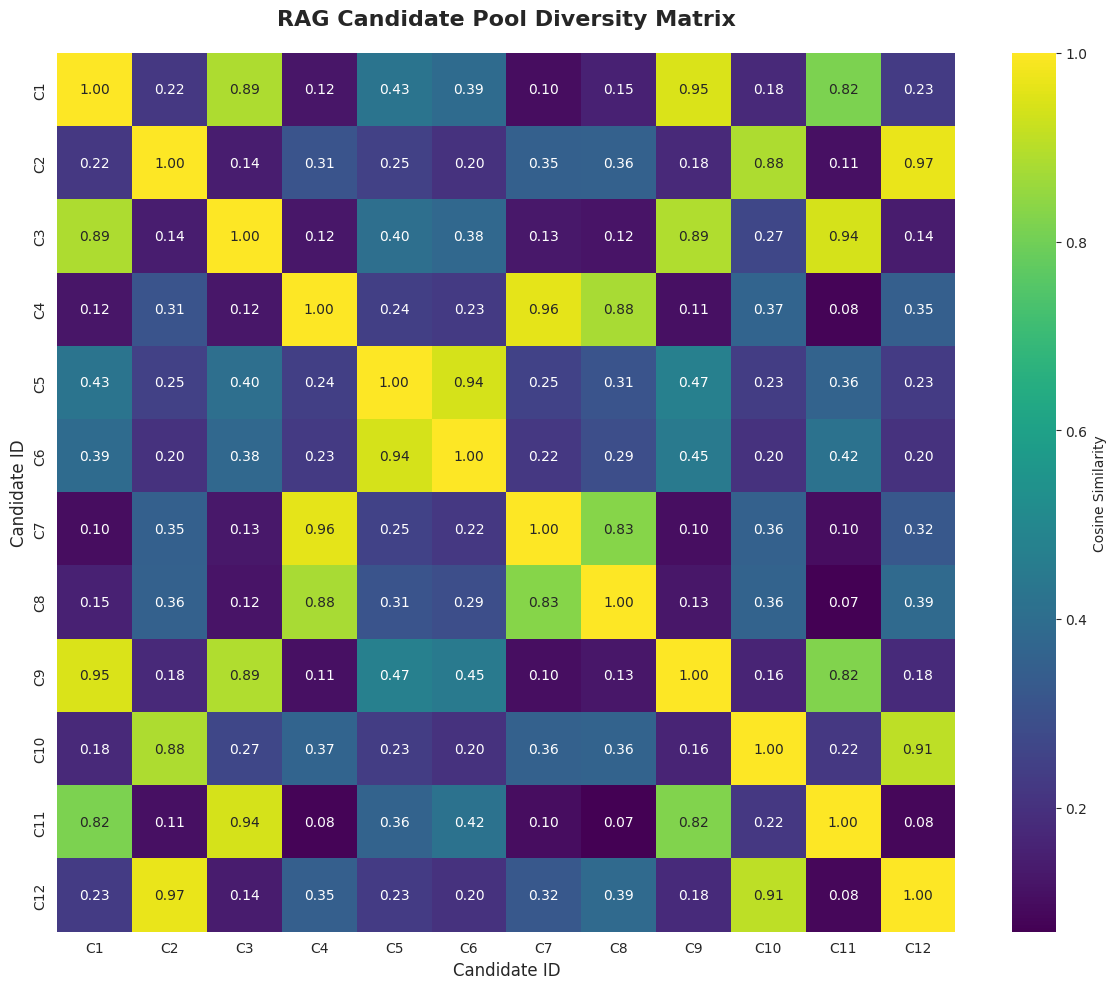

\n✓ Generated 12 diverse RAG candidates
  Average pairwise similarity: 0.370
  Diversity score: 0.630

[Step 2] Evaluating Initial Candidates...


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 31.08it/s]




ITERATION 1/3

[Step 3.1] Pareto Filtering...


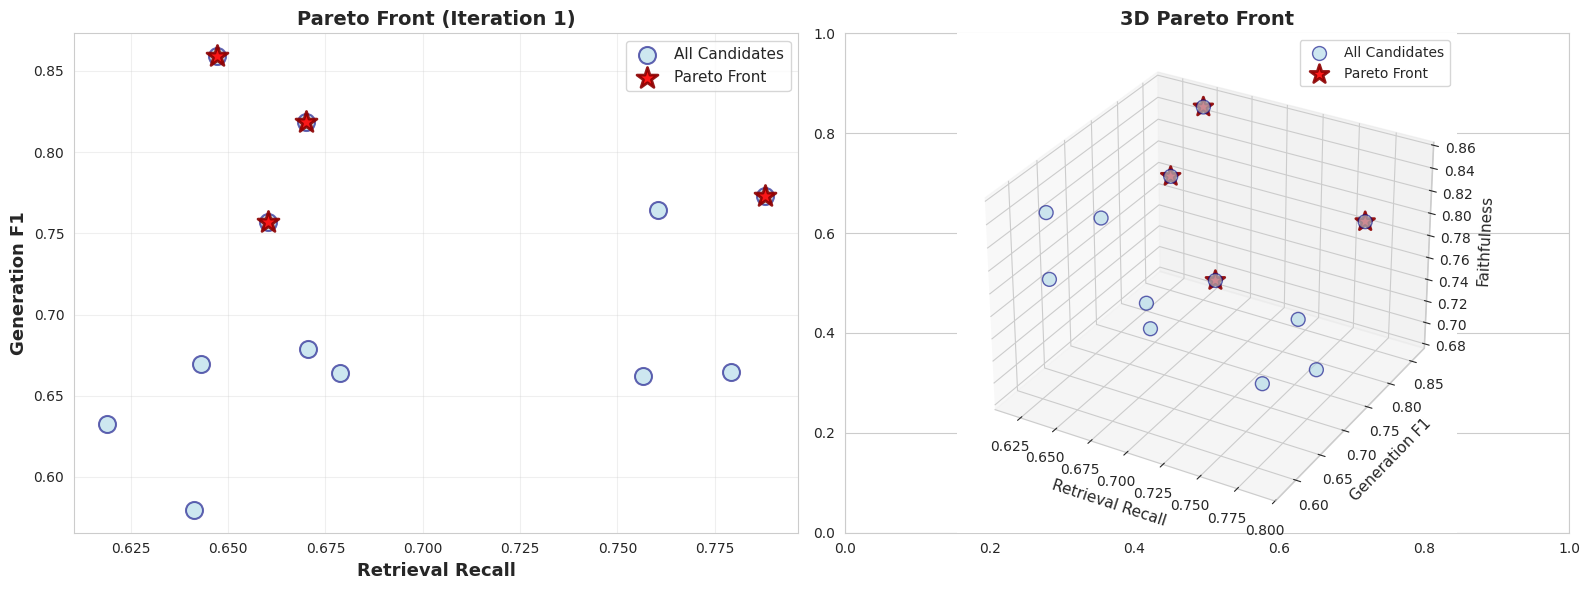


✓ Pareto front: 4/12 candidates selected

[Step 4.1] Reflective Mutation...


Mutating: 100%|██████████| 4/4 [00:00<00:00, 26.05it/s]



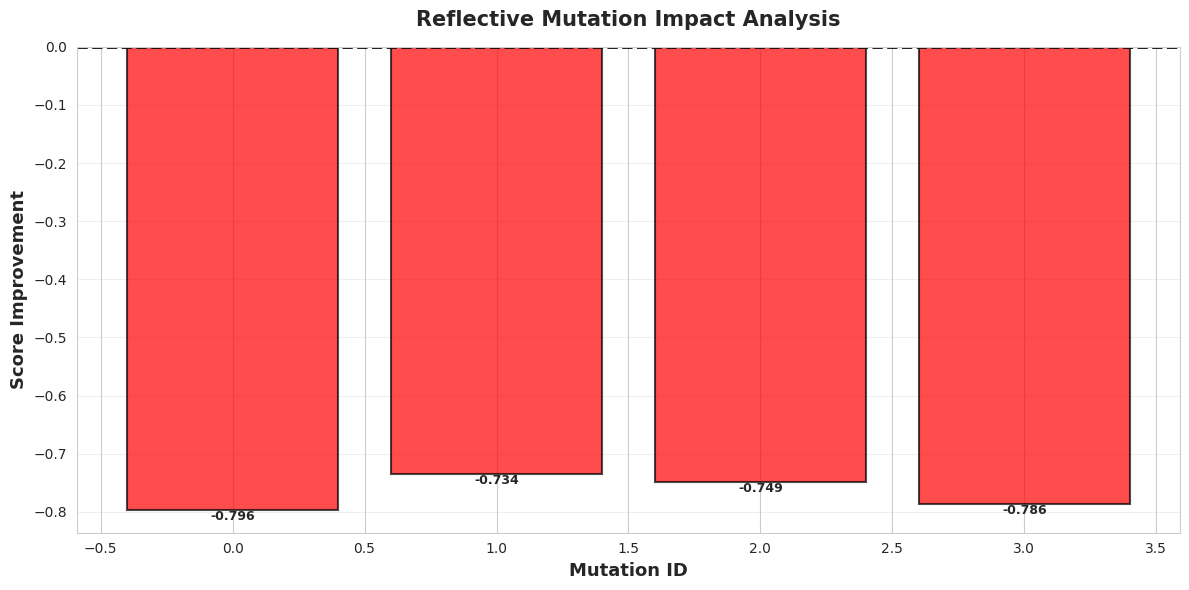


✓ Mutations analyzed: 4
  Average improvement: -0.766
  Positive mutations: 0/4

[Step 5.1] System-Aware Merge...


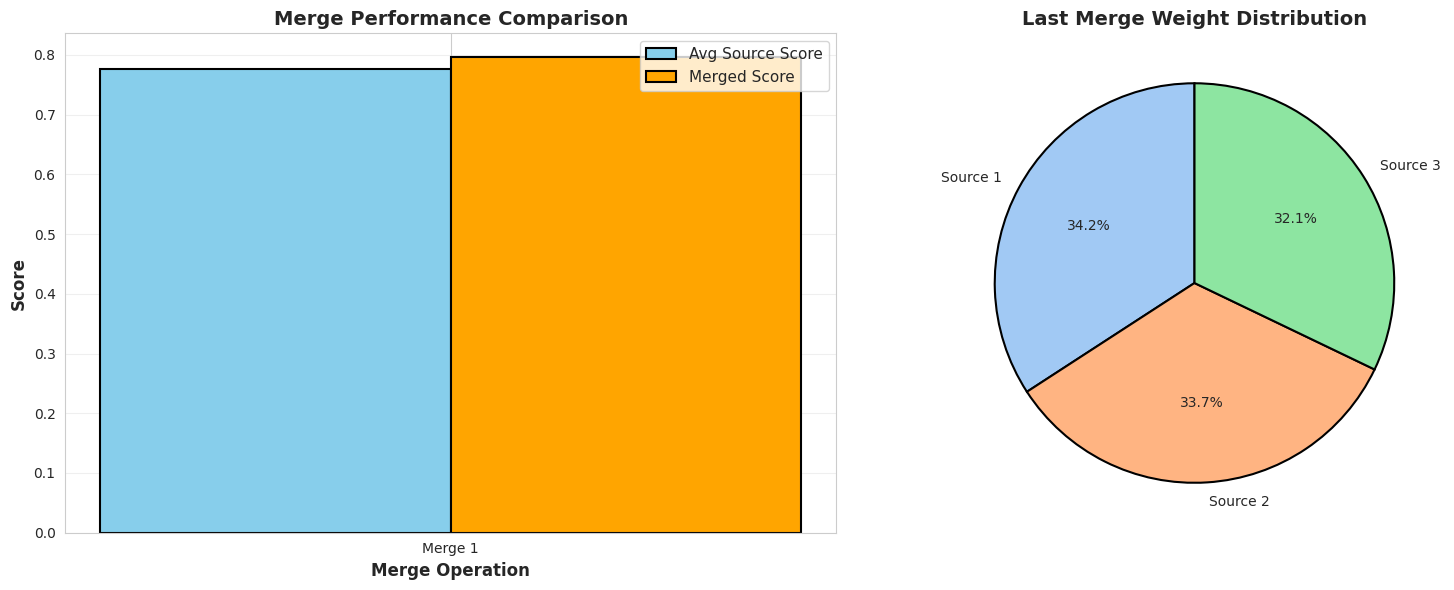


✓ Merge operations: 1

ITERATION 2/3

[Step 3.2] Pareto Filtering...


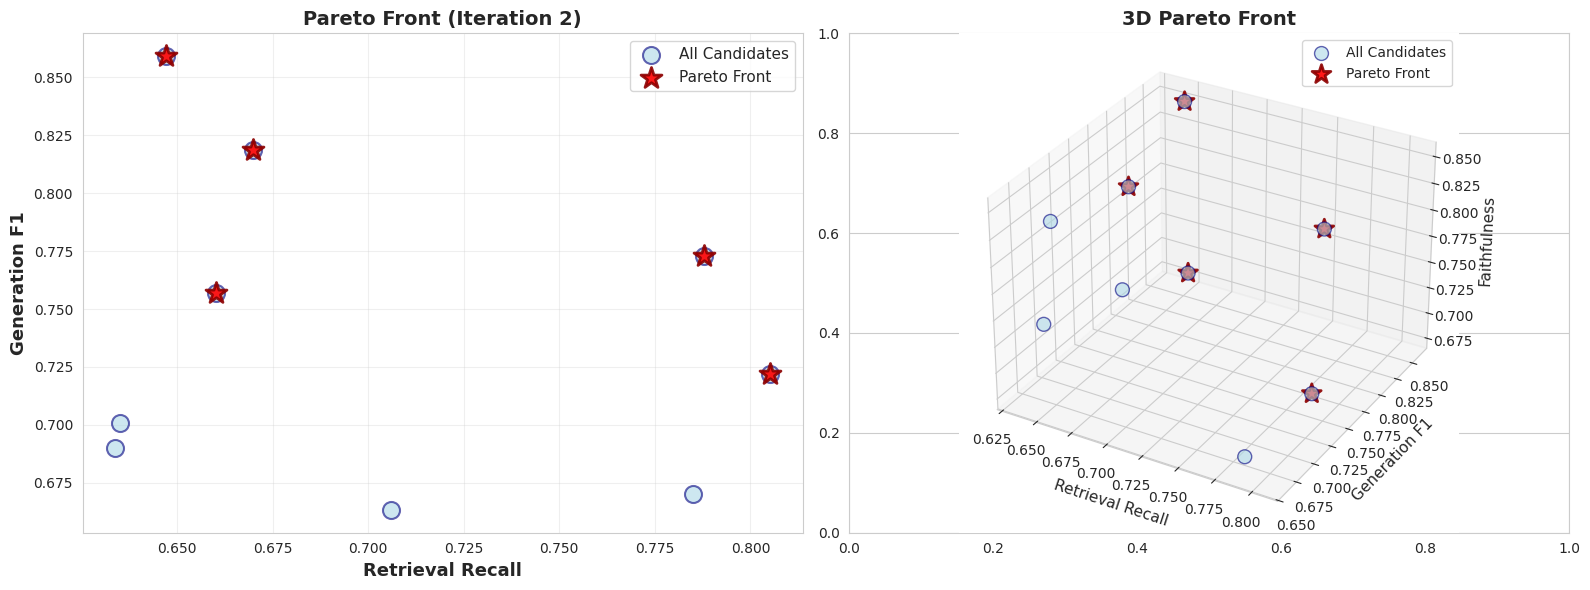


✓ Pareto front: 5/9 candidates selected

[Step 4.2] Reflective Mutation...


Mutating: 100%|██████████| 5/5 [00:00<00:00, 21.67it/s]



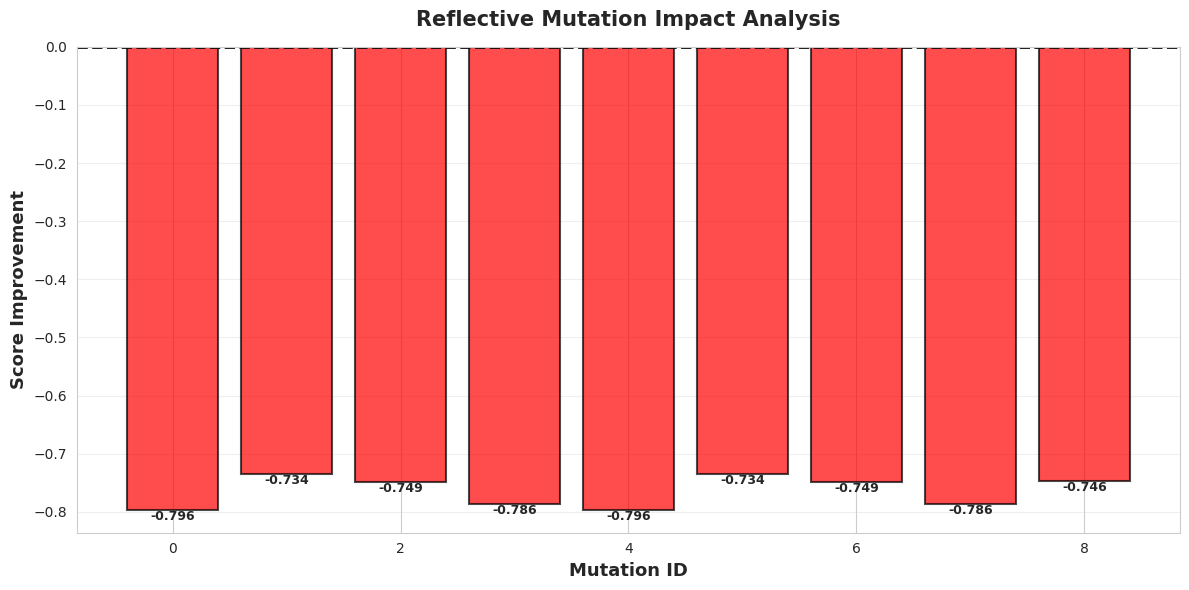


✓ Mutations analyzed: 9
  Average improvement: -0.764
  Positive mutations: 0/9

[Step 5.2] System-Aware Merge...


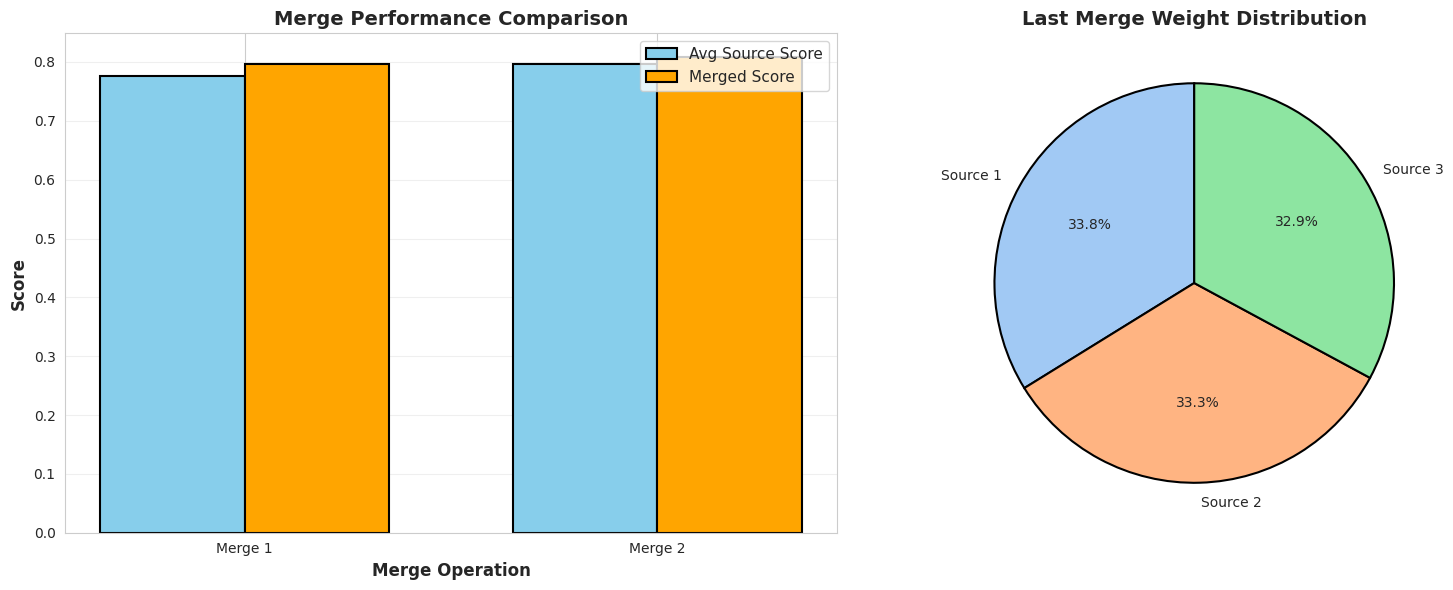


✓ Merge operations: 2

ITERATION 3/3

[Step 3.3] Pareto Filtering...


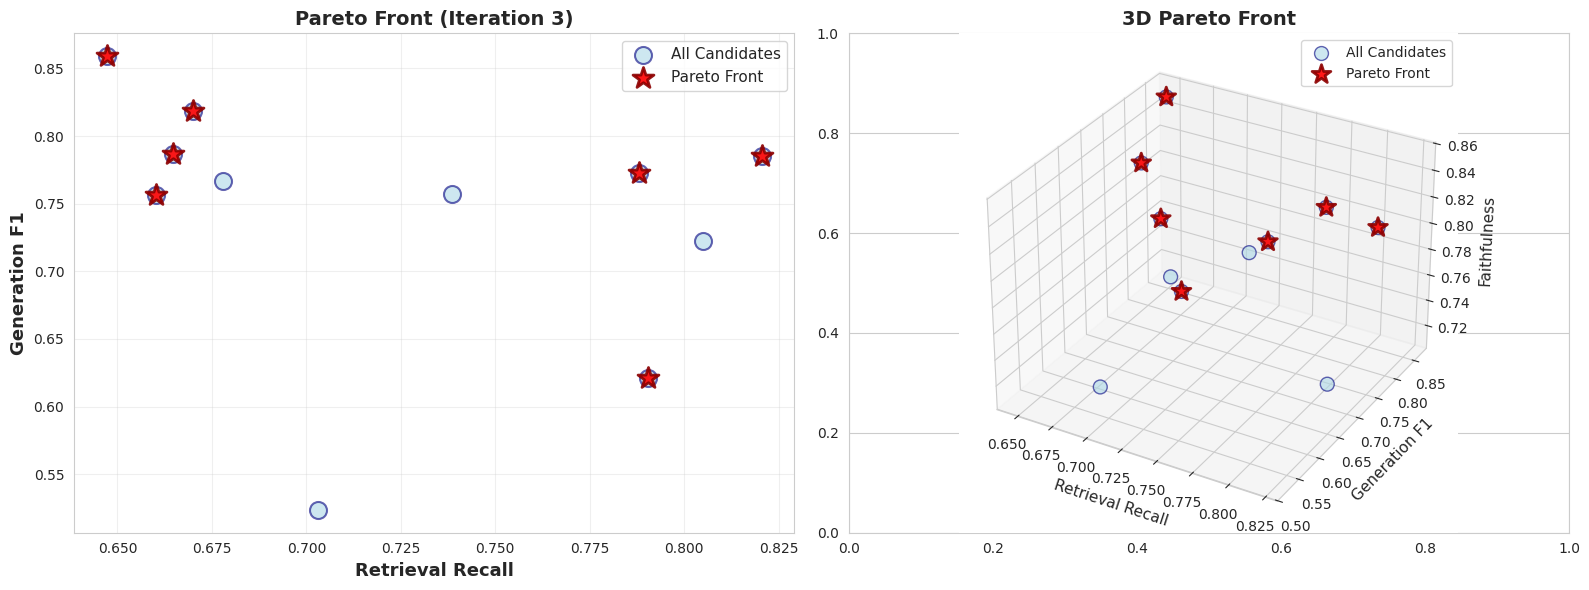


✓ Pareto front: 7/11 candidates selected

[Step 4.3] Reflective Mutation...


Mutating: 100%|██████████| 5/5 [00:00<00:00, 18.04it/s]



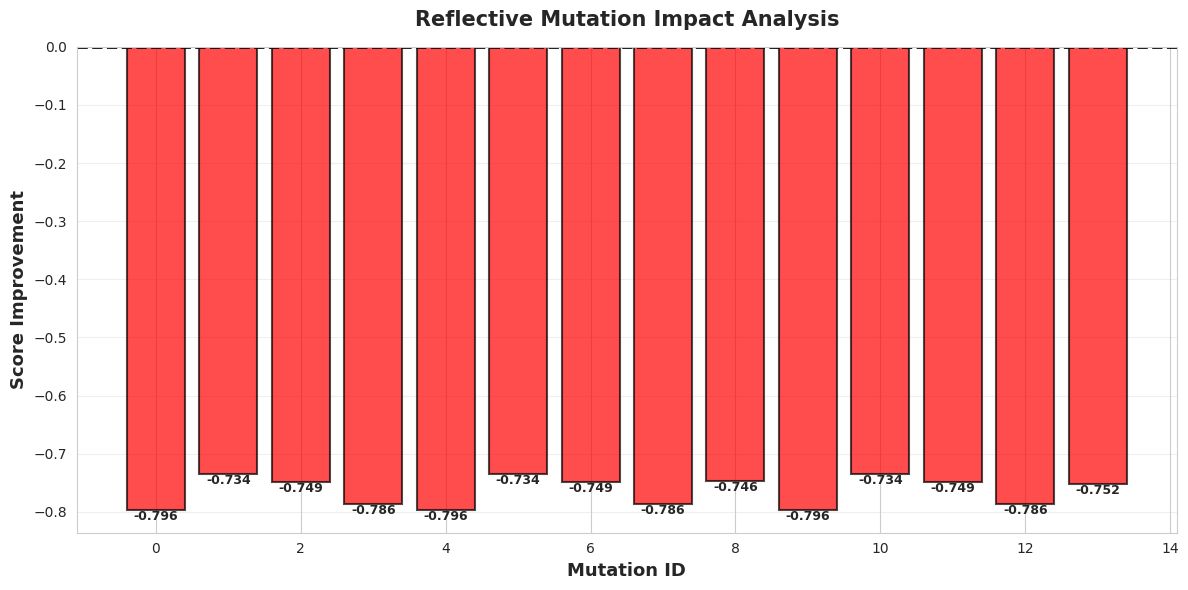


✓ Mutations analyzed: 14
  Average improvement: -0.764
  Positive mutations: 0/14

[Step 5.3] System-Aware Merge...


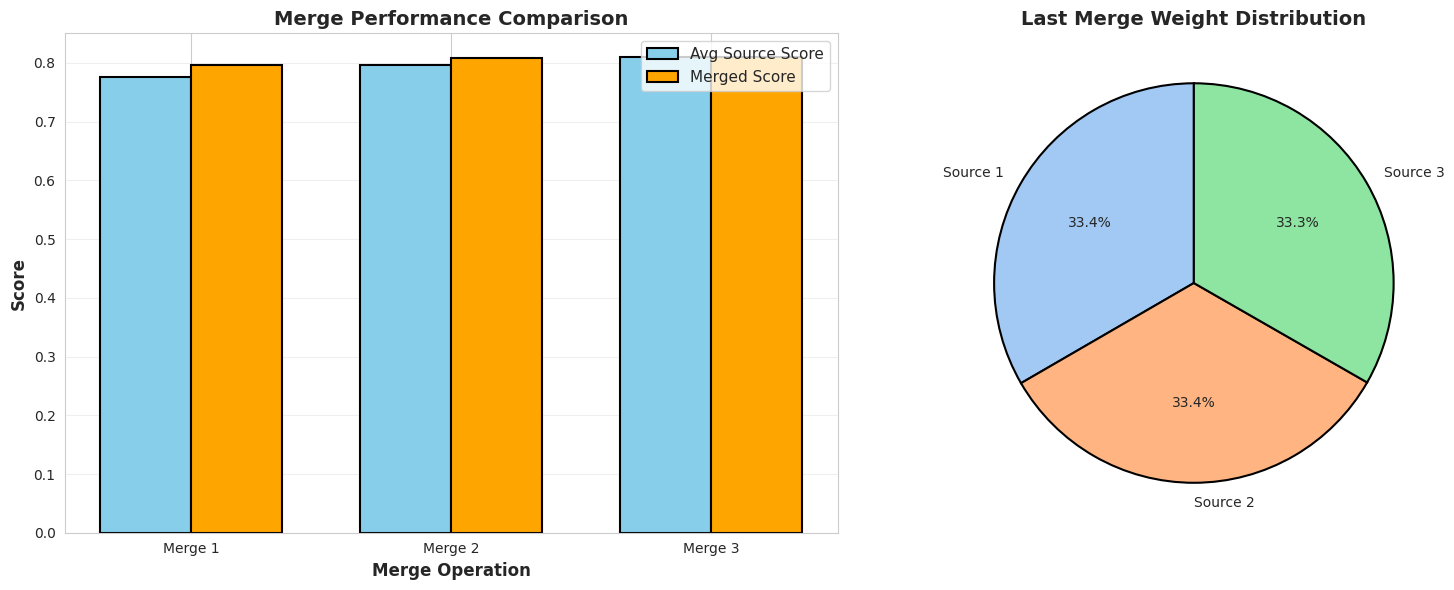


✓ Merge operations: 3

✓ Optimization Complete!
  Final Best Score: 0.8099


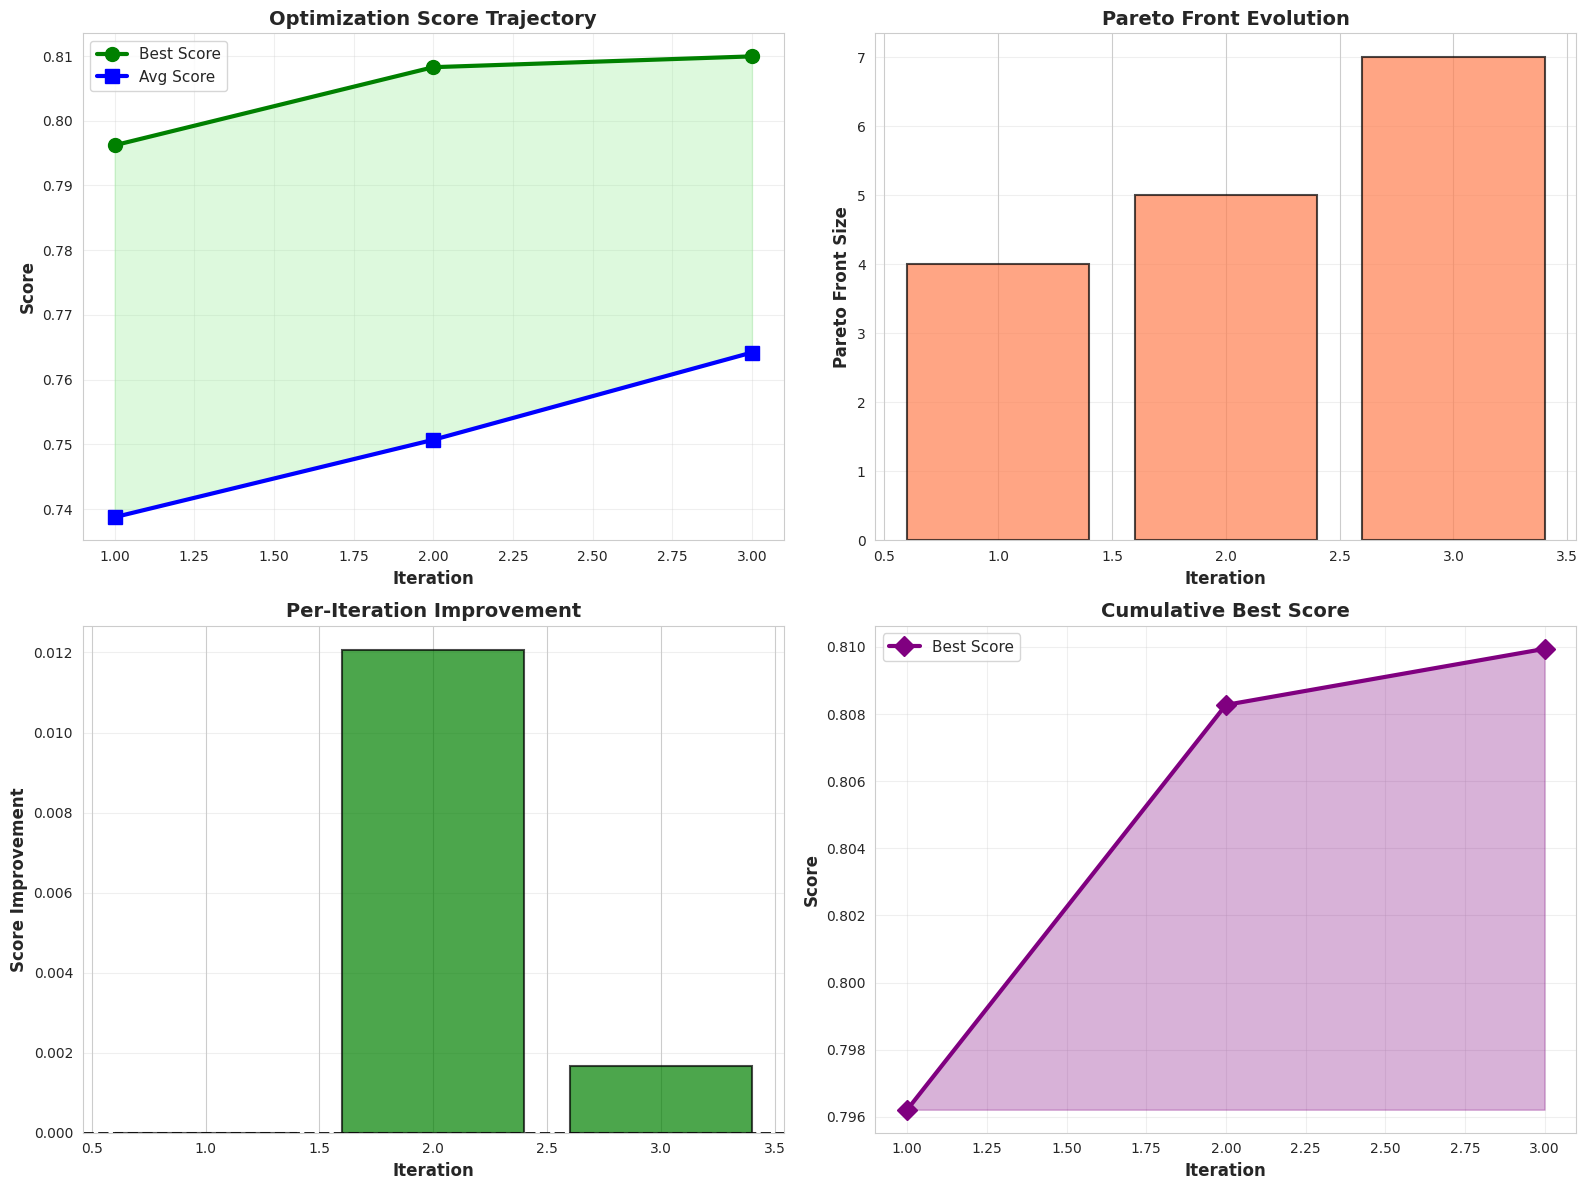


✓ Total improvement: 0.0137
  Initial best: 0.7962
  Final best: 0.8099

Evaluating GEPA RAG on all questions...


GEPA RAG: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


GEPA RAG evaluation complete


In [15]:
print("\n" + "="*80)
print("RUNNING GEPA RAG")
print("="*80)

gepa_rag = GEPARAG(index=vector_index, k=4, n_iterations=3)

# Optimize on subset
print("\nOptimizing GEPA RAG...")
gepa_rag.optimize(test_questions[:5])  # Use first 5 for optimization

# Evaluate on all questions
print("\nEvaluating GEPA RAG on all questions...")
gepa_results = []

for i, qa in enumerate(tqdm(test_questions, desc="GEPA RAG")):
    example = dspy.Example(
        question=qa['question'],
        answer=qa['answer']
    ).with_inputs("question")
    
    pred = gepa_rag(question=example.question)
    metrics = rag_metric(example, pred)
    
    gepa_results.append({
        'question': qa['question'],
        'answer': pred.answer,
        'metrics': metrics
    })

print("\nGEPA RAG evaluation complete")


COMPARATIVE ANALYSIS

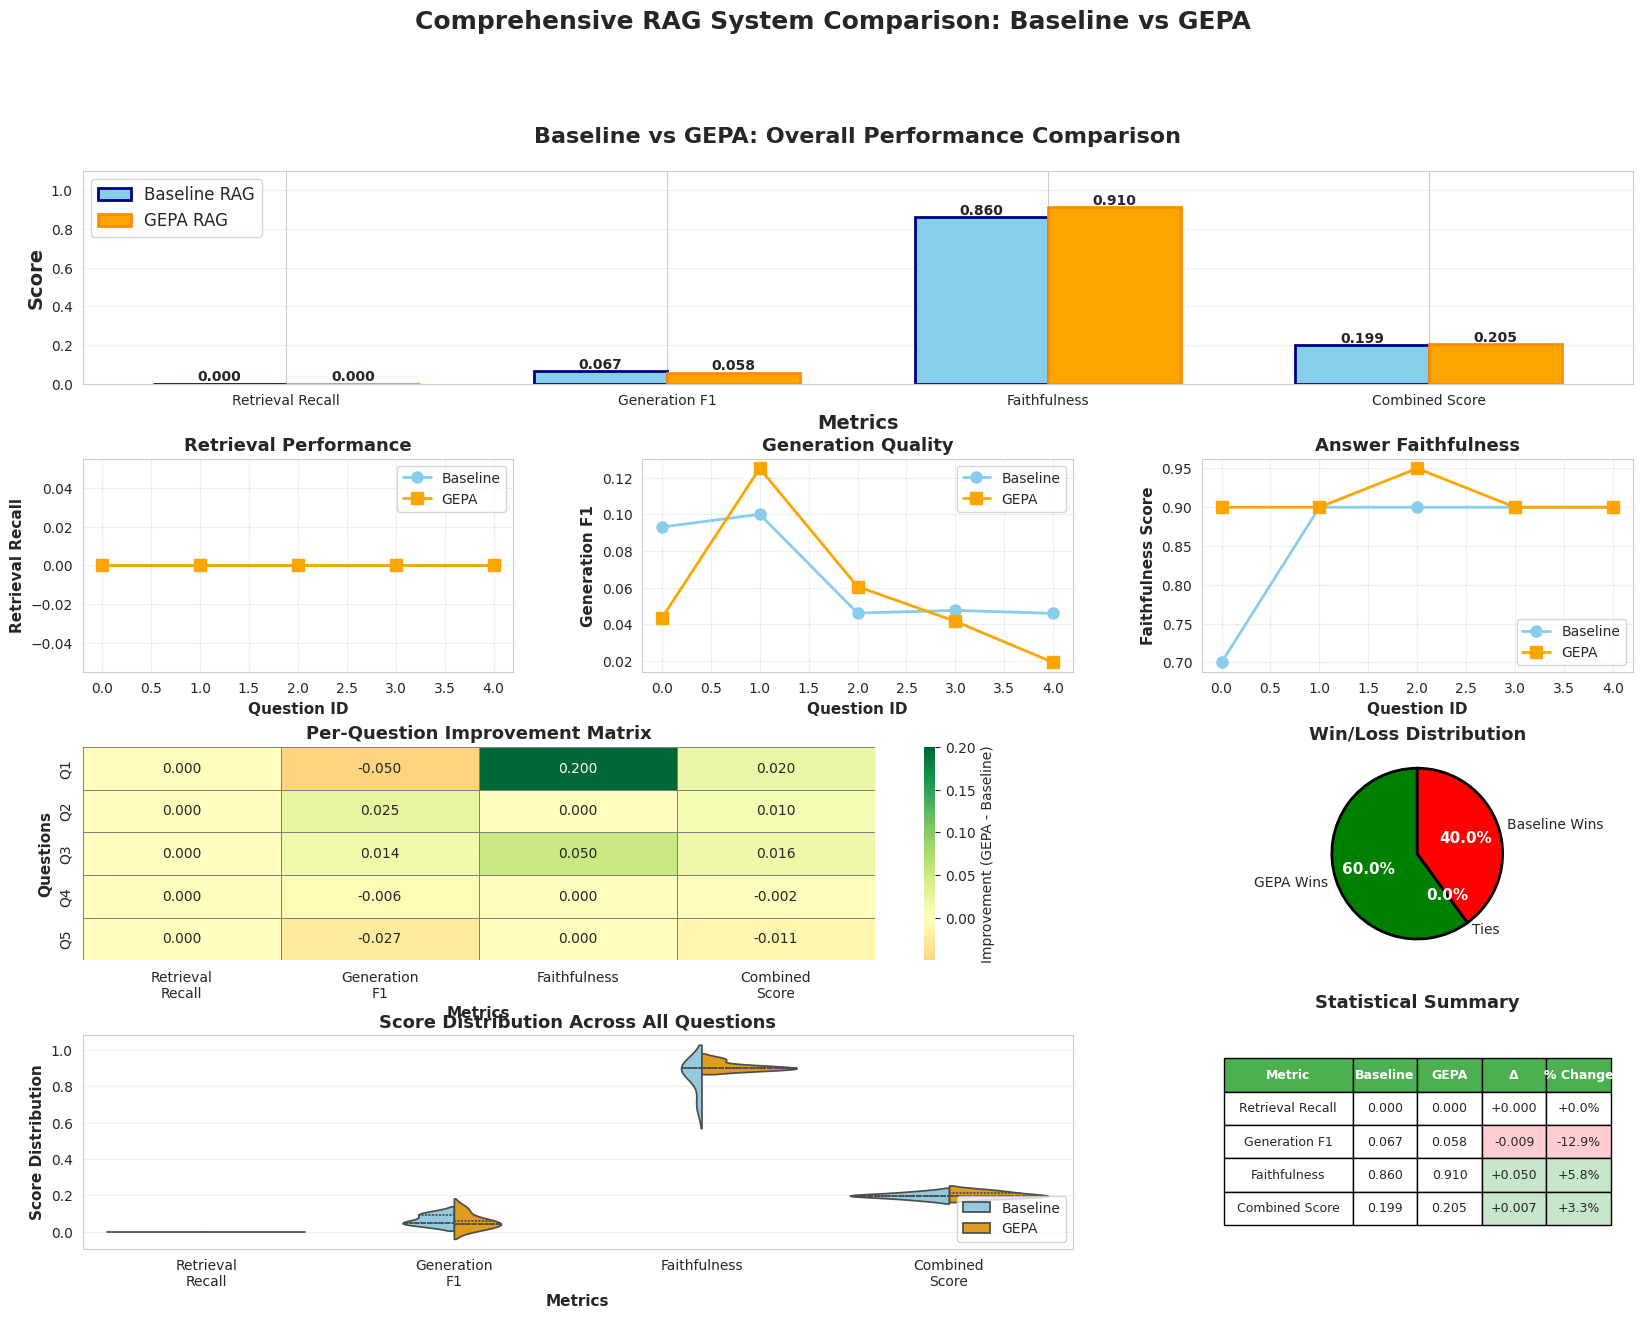


COMPARISON SUMMARY

Retrieval Recall:
  Baseline: 0.0000
  GEPA:     0.0000
  Improvement: +0.0000 (+0.00%)

Generation F1:
  Baseline: 0.0666
  GEPA:     0.0580
  Improvement: -0.0086 (-12.86%)

Faithfulness:
  Baseline: 0.8600
  GEPA:     0.9100
  Improvement: +0.0500 (+5.81%)

Combined Score:
  Baseline: 0.1986
  GEPA:     0.2052
  Improvement: +0.0066 (+3.31%)

Win/Loss/Tie: 3/2/0
GEPA Win Rate: 60.0%

DETAILED QUESTION-BY-QUESTION ANALYSIS

QUESTION 1: What is the eye of the machine?

Gold Answer: computer vision and pattern recognition systems

Baseline Answer: The "eye of the machine" refers to the component or system of a machine, such as a computer or robot, that allows it to process and interpret visual information from its environment, analogous to the ...

GEPA Answer: The "eye of the machine" refers to the ability of machines to interpret and understand visual data through the use of deep neural networks, which are modeled after the human visual system and can lear...

Me

In [16]:
def compare_rag_systems(baseline_results: List[Dict], 
                       gepa_results: List[Dict]):
    """Comprehensive comparison of baseline vs GEPA"""
    
    # Extract metrics
    baseline_metrics = [r['metrics'] for r in baseline_results]
    gepa_metrics = [r['metrics'] for r in gepa_results]
    
    # Aggregate scores
    metric_names = ['retrieval_recall', 'generation_f1', 'faithfulness', 'combined_score']
    
    baseline_avg = {
        m: np.mean([metrics[m] for metrics in baseline_metrics])
        for m in metric_names
    }
    
    gepa_avg = {
        m: np.mean([metrics[m] for metrics in gepa_metrics])
        for m in metric_names
    }
    
    # Create comprehensive comparison visualization
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)
    
    # 1. Overall metric comparison (bar chart)
    ax1 = fig.add_subplot(gs[0, :])
    x = np.arange(len(metric_names))
    width = 0.35
    
    baseline_vals = [baseline_avg[m] for m in metric_names]
    gepa_vals = [gepa_avg[m] for m in metric_names]
    
    bars1 = ax1.bar(x - width/2, baseline_vals, width, label='Baseline RAG', 
                   color='skyblue', edgecolor='navy', linewidth=2)
    bars2 = ax1.bar(x + width/2, gepa_vals, width, label='GEPA RAG', 
                   color='orange', edgecolor='darkorange', linewidth=2)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    ax1.set_xlabel('Metrics', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax1.set_title('Baseline vs GEPA: Overall Performance Comparison', 
                 fontsize=16, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.replace('_', ' ').title() for m in metric_names])
    ax1.legend(fontsize=12, loc='upper left')
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Per-question comparison (retrieval recall)
    ax2 = fig.add_subplot(gs[1, 0])
    questions_idx = range(len(test_questions))
    baseline_retrieval = [m['retrieval_recall'] for m in baseline_metrics]
    gepa_retrieval = [m['retrieval_recall'] for m in gepa_metrics]
    
    ax2.plot(questions_idx, baseline_retrieval, marker='o', linewidth=2, 
            markersize=8, label='Baseline', color='skyblue')
    ax2.plot(questions_idx, gepa_retrieval, marker='s', linewidth=2, 
            markersize=8, label='GEPA', color='orange')
    ax2.set_xlabel('Question ID', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Retrieval Recall', fontsize=11, fontweight='bold')
    ax2.set_title('Retrieval Performance', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 3. Per-question comparison (generation F1)
    ax3 = fig.add_subplot(gs[1, 1])
    baseline_generation = [m['generation_f1'] for m in baseline_metrics]
    gepa_generation = [m['generation_f1'] for m in gepa_metrics]
    
    ax3.plot(questions_idx, baseline_generation, marker='o', linewidth=2, 
            markersize=8, label='Baseline', color='skyblue')
    ax3.plot(questions_idx, gepa_generation, marker='s', linewidth=2, 
            markersize=8, label='GEPA', color='orange')
    ax3.set_xlabel('Question ID', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Generation F1', fontsize=11, fontweight='bold')
    ax3.set_title('Generation Quality', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # 4. Per-question comparison (faithfulness)
    ax4 = fig.add_subplot(gs[1, 2])
    baseline_faithfulness = [m['faithfulness'] for m in baseline_metrics]
    gepa_faithfulness = [m['faithfulness'] for m in gepa_metrics]
    
    ax4.plot(questions_idx, baseline_faithfulness, marker='o', linewidth=2, 
            markersize=8, label='Baseline', color='skyblue')
    ax4.plot(questions_idx, gepa_faithfulness, marker='s', linewidth=2, 
            markersize=8, label='GEPA', color='orange')
    ax4.set_xlabel('Question ID', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Faithfulness Score', fontsize=11, fontweight='bold')
    ax4.set_title('Answer Faithfulness', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    # 5. Improvement heatmap
    ax5 = fig.add_subplot(gs[2, :2])
    improvements = np.array([
        [gepa_metrics[i][m] - baseline_metrics[i][m] 
         for m in metric_names]
        for i in range(len(test_questions))
    ])
    
    sns.heatmap(improvements, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
               xticklabels=[m.replace('_', '\n').title() for m in metric_names],
               yticklabels=[f"Q{i+1}" for i in range(len(test_questions))],
               cbar_kws={'label': 'Improvement (GEPA - Baseline)'},
               ax=ax5, linewidths=0.5, linecolor='gray')
    ax5.set_title('Per-Question Improvement Matrix', fontsize=13, fontweight='bold')
    ax5.set_xlabel('Metrics', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Questions', fontsize=11, fontweight='bold')
    
    # 6. Win/Loss/Tie distribution
    ax6 = fig.add_subplot(gs[2, 2])
    wins = sum(1 for i in range(len(test_questions)) 
              if gepa_metrics[i]['combined_score'] > baseline_metrics[i]['combined_score'])
    losses = sum(1 for i in range(len(test_questions)) 
                if gepa_metrics[i]['combined_score'] < baseline_metrics[i]['combined_score'])
    ties = len(test_questions) - wins - losses
    
    categories = ['GEPA Wins', 'Ties', 'Baseline Wins']
    values = [wins, ties, losses]
    colors_pie = ['green', 'gray', 'red']
    
    wedges, texts, autotexts = ax6.pie(values, labels=categories, autopct='%1.1f%%',
                                        startangle=90, colors=colors_pie,
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 2})
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    ax6.set_title('Win/Loss Distribution', fontsize=13, fontweight='bold')
    
    # 7. Score distribution (violin plot)
    ax7 = fig.add_subplot(gs[3, :2])
    
    data_violin = []
    labels_violin = []
    for m in metric_names:
        data_violin.extend([baseline_avg[m], gepa_avg[m]])
        labels_violin.extend(['Baseline', 'GEPA'])
    
    # Prepare data for violin plot
    violin_df = pd.DataFrame({
        'System': ['Baseline'] * len(test_questions) * len(metric_names) + 
                  ['GEPA'] * len(test_questions) * len(metric_names),
        'Metric': [m for m in metric_names for _ in range(len(test_questions))] * 2,
        'Score': [baseline_metrics[i][m] for m in metric_names for i in range(len(test_questions))] +
                 [gepa_metrics[i][m] for m in metric_names for i in range(len(test_questions))]
    })
    
    sns.violinplot(data=violin_df, x='Metric', y='Score', hue='System',
                  split=True, inner='quart', palette=['skyblue', 'orange'], ax=ax7)
    ax7.set_xlabel('Metrics', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Score Distribution', fontsize=11, fontweight='bold')
    ax7.set_title('Score Distribution Across All Questions', fontsize=13, fontweight='bold')
    ax7.set_xticklabels([m.replace('_', '\n').title() for m in metric_names])
    ax7.legend(fontsize=10, loc='lower right')
    ax7.grid(True, alpha=0.3, axis='y')
    
    # 8. Statistical summary table
    ax8 = fig.add_subplot(gs[3, 2])
    ax8.axis('off')
    
    summary_data = []
    for m in metric_names:
        baseline_val = baseline_avg[m]
        gepa_val = gepa_avg[m]
        improvement = gepa_val - baseline_val
        pct_improvement = (improvement / baseline_val * 100) if baseline_val > 0 else 0
        
        summary_data.append([
            m.replace('_', ' ').title(),
            f"{baseline_val:.3f}",
            f"{gepa_val:.3f}",
            f"{improvement:+.3f}",
            f"{pct_improvement:+.1f}%"
        ])
    
    table = ax8.table(cellText=summary_data,
                     colLabels=['Metric', 'Baseline', 'GEPA', 'Δ', '% Change'],
                     cellLoc='center', loc='center',
                     colWidths=[0.3, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code improvements
    for i in range(1, len(summary_data) + 1):
        improvement_val = float(summary_data[i-1][3])
        if improvement_val > 0:
            table[(i, 3)].set_facecolor('#C8E6C9')
            table[(i, 4)].set_facecolor('#C8E6C9')
        elif improvement_val < 0:
            table[(i, 3)].set_facecolor('#FFCDD2')
            table[(i, 4)].set_facecolor('#FFCDD2')
    
    ax8.set_title('Statistical Summary', fontsize=13, fontweight='bold', pad=20)
    
    plt.suptitle('Comprehensive RAG System Comparison: Baseline vs GEPA', 
                fontsize=18, fontweight='bold', y=0.995)
    
    plt.savefig('rag_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("COMPARISON SUMMARY")
    print("="*80)
    
    for m in metric_names:
        baseline_val = baseline_avg[m]
        gepa_val = gepa_avg[m]
        improvement = gepa_val - baseline_val
        pct_improvement = (improvement / baseline_val * 100) if baseline_val > 0 else 0
        
        print(f"\n{m.replace('_', ' ').title()}:")
        print(f"  Baseline: {baseline_val:.4f}")
        print(f"  GEPA:     {gepa_val:.4f}")
        print(f"  Improvement: {improvement:+.4f} ({pct_improvement:+.2f}%)")
    
    print(f"\n{'='*80}")
    print(f"Win/Loss/Tie: {wins}/{losses}/{ties}")
    print(f"GEPA Win Rate: {wins/len(test_questions)*100:.1f}%")
    print(f"{'='*80}")

# Run comparison
compare_rag_systems(baseline_results, gepa_results)

# ============================================================================
# BLOCK 17: DETAILED QUESTION-BY-QUESTION ANALYSIS
# ============================================================================

def detailed_question_analysis(baseline_results: List[Dict], 
                              gepa_results: List[Dict],
                              test_questions: List[Dict]):
    """Detailed analysis of each question"""
    
    print("\n" + "="*80)
    print("DETAILED QUESTION-BY-QUESTION ANALYSIS")
    print("="*80)
    
    for i, qa in enumerate(test_questions):
        print(f"\n{'='*80}")
        print(f"QUESTION {i+1}: {qa['question']}")
        print(f"{'='*80}")
        
        baseline_m = baseline_results[i]['metrics']
        gepa_m = gepa_results[i]['metrics']
        
        print(f"\nGold Answer: {qa['answer']}")
        print(f"\nBaseline Answer: {baseline_results[i]['answer'][:200]}...")
        print(f"\nGEPA Answer: {gepa_results[i]['answer'][:200]}...")
        
        print(f"\n{'Metric':<20} {'Baseline':<12} {'GEPA':<12} {'Improvement':<12}")
        print("-" * 56)
        
        for metric in ['retrieval_recall', 'generation_f1', 'faithfulness', 'combined_score']:
            b_val = baseline_m[metric]
            g_val = gepa_m[metric]
            improvement = g_val - b_val
            
            symbol = "✓" if improvement > 0 else "✗" if improvement < 0 else "="
            print(f"{metric:<20} {b_val:<12.4f} {g_val:<12.4f} {improvement:+.4f} {symbol}")
        
        # Determine winner
        if gepa_m['combined_score'] > baseline_m['combined_score']:
            winner = "🏆 GEPA WINS"
            color = "green"
        elif gepa_m['combined_score'] < baseline_m['combined_score']:
            winner = "🏆 BASELINE WINS"
            color = "red"
        else:
            winner = "🤝 TIE"
            color = "gray"
        
        print(f"\n{winner}")

detailed_question_analysis(baseline_results, gepa_results, test_questions)

print("\n" + "="*80)
print("✓ COMPLETE RAG COMPARISON FINISHED")
print("="*80)
print("\nGenerated visualizations:")
print("  - rag_candidate_diversity.png")
print("  - rag_pareto_front_iter*.png")
print("  - rag_mutation_impact.png")
print("  - rag_merge_strategy.png")
print("  - rag_optimization_trajectory.png")
print("  - rag_comprehensive_comparison.png")